Isolation Forest algorithm:
- The Isolation Forest algorithm is a type of unsupervised learning algorithm used for anomaly detection. It isolates anomalies instead of profiling normal data points, which is the common approach in most anomaly detection algorithms. The method is particularly efficient for datasets with a high dimensionality.
- Anomalies are few and different, which makes them easier to isolate.
- The algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.
-  the maximum depth of each tree is set to [log(n)] --> base is 2 -  where n is the number of samples used to build the tree


- How It Works
- - Random Partitioning: The algorithm works by recursively partitioning the dataset. In each iteration, it randomly selects a feature and then randomly selects a split value for the feature, effectively dividing the dataset into two subsets. This process is repeated until each data point is isolated or a specified limit is reached.

- - Path Length: Each time a data point is isolated, the number of splits it took to isolate the data point is recorded. This number is referred to as the 'path length'. Anomalies are generally isolated in fewer splits than normal points, leading to shorter path lengths.

- - Ensemble Approach: The Isolation Forest creates multiple such decision trees (a forest) and then averages the path lengths to determine the anomaly score for each data point. Shorter average path lengths indicate anomalies.


- Algorithm Steps
- - Create Isolation Trees (iTrees): For each iTree in the forest:
- - - Randomly sample a subset of the data.
- - - Recursively divide the dataset by randomly selecting a feature and a random split value within the range of that feature, until each point is isolated or a limit in tree depth is reached.
- - Calculate Path Lengths: For each data point, traverse each iTree to calculate the path length from the root node to the leaf node. The path length is the number of edges the point passes through.

- - Determine Anomaly Score: The anomaly score is calculated based on the average path length across all iTrees. Shorter paths are more indicative of anomalies. The score is normalized to fall between 0 and 1.

- - Classification: Data points with anomaly scores above a certain threshold are classified as anomalies.



In [24]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import DecisionBoundaryDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import joblib

In [7]:
# Loading the data - Note Since Isolation Forest is a tree-based method, it does not require feature scaling.
df = joblib.load('df_chosen_features.csv')

# Need to drop the NaN values
df = df.dropna(subset=['tcp.len'])

# Reshape to make it a 2D array
x = df[['tcp.len']].values



In [10]:
# Building the classifier
# The ensemble.IsolationForest supports warm_start=True which allows you to add more trees to an already fitted model
# The amount of contamination of the data set, i.e. the proportion of outliers in the data set. Used when fitting to define the threshold on the scores of the samples.
# bootstrap: bool, default=False --> If True, individual trees are fit on random subsets of the training data sampled with replacement. If False, sampling without replacement is performed.

clf = IsolationForest(n_estimators=100,
                      max_samples='auto',
                      contamination='auto',
                      random_state=42,
                      verbose=1)

clf.fit(x)

IsolationForest(random_state=42, verbose=1)

In [11]:
# Obtaining Anomaly Scores and Predictions : The decision_function method returns the anomaly score for each sample, and the predict method returns the prediction (-1 for outliers, 1 for inliers).

scores = clf.decision_function(x)
predictions = clf.predict(x)

In [16]:
# Evaluating the Model
filepath = "attack-sample.csv"
df_original = pd.read_csv(filepath)
sub_df_original = df_original.loc[:, ['tcp.len', 'alert']]
sub_df_original = sub_df_original.dropna(subset=['tcp.len'])

# Convert 'alert' to a binary format where 'suspicious' is -1 and 'benign' is 1
sub_df_original['alert'] = sub_df_original['alert'].replace({'suspicious': -1, 'benign': 1})
sub_df_original['predictions'] = predictions

# Evaluation metrics

TP = ((sub_df_original['alert'] == -1) & (sub_df_original['predictions'] == -1)).sum()
FP = ((sub_df_original['alert'] == 1) & (sub_df_original['predictions'] == -1)).sum()
FN = ((sub_df_original['alert'] == -1) & (sub_df_original['predictions'] == 1)).sum()

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f'Precision is: {precision} \nRecall is: {recall}')

#
# print(confusion_matrix(true_labels, predictions))
# print(classification_report(true_labels, predictions))

/tmp/ipykernel_419078/1144325066.py:3: DtypeWarning: Columns (34,37,44,50,52,54,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv(filepath)


Precision is: 0.9977551855214455 
Recall is: 0.4015797198346394


In [20]:
print(classification_report(sub_df_original['alert'], sub_df_original['predictions']))

              precision    recall  f1-score   support

          -1       1.00      0.40      0.57    996126
           1       0.00      0.66      0.01      2652

    accuracy                           0.40    998778
   macro avg       0.50      0.53      0.29    998778
weighted avg       1.00      0.40      0.57    998778



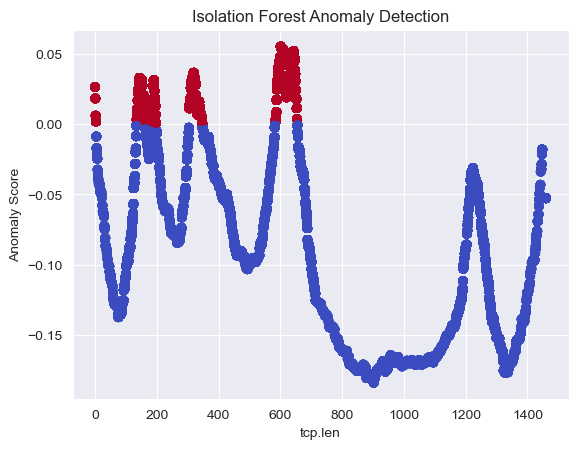

In [21]:
plt.scatter(sub_df_original['tcp.len'], scores, c=predictions, cmap='coolwarm')
plt.xlabel('tcp.len')
plt.ylabel('Anomaly Score')
plt.title('Isolation Forest Anomaly Detection')
plt.show()

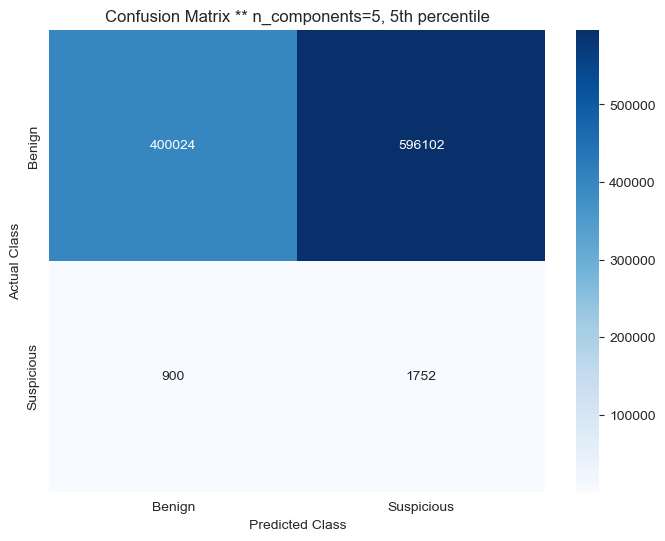

In [19]:
cm = confusion_matrix(sub_df_original['alert'], sub_df_original['predictions'])


plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Benign', 'Suspicious'],
            yticklabels=['Benign', 'Suspicious'])
plt.title('Confusion Matrix ** n_components=5, 5th percentile')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

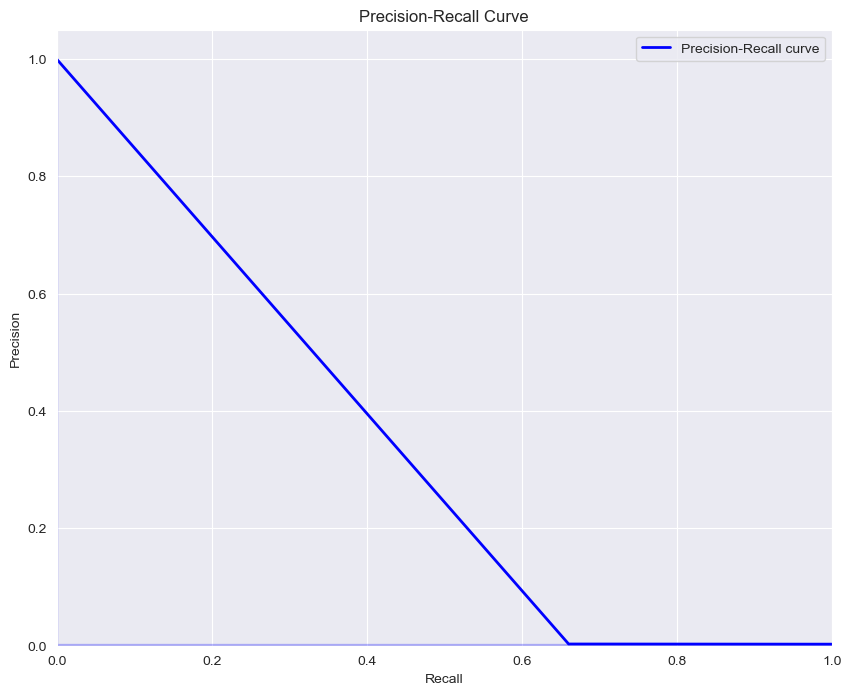

In [23]:
precision, recall, thresholds = precision_recall_curve(sub_df_original['alert'], sub_df_original['predictions'])

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.show()

Considering  clf = IsolationForest(n_estimators=100,
                      max_samples='auto',
                      contamination='auto',
                      random_state=42,
                      verbose=1)
I'm getting a much better result : Precision is: 0.9977551855214455 & Recall is: 0.4015797198346394